# Check Orion & Jupyter Setup

This notebook is a quick test whether your setup on Orion is fully functional for the workshop. Follow the setup instructions in the [README](https://github.com/VulcanClimateModeling/dsl_workshop/blob/main/README.md) and then execute all cells in this notebook to make sure everything is ok.

## Check Numpy and Matplotlib Setup

Ensure that numpy and matplotlib are installed correctly. A plot of a random number field should show below.

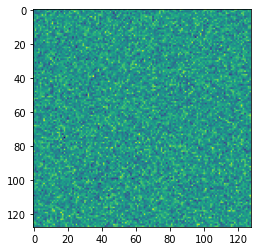

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.random.randn(128, 128))

## Check GT4Py Setup

Check that the GT4Py package is installed correctly. You should get no error messages when executing the cells below.

In [2]:
import numpy as np
import gt4py
from gt4py import gtscript

In [3]:
@gtscript.stencil(backend="numpy")
def copy_stencil(in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]):
    with computation(FORWARD):
        with interval(...):
            out_storage = in_storage

In [4]:
shape = (1, 10, 10)
in_storage = gt4py.storage.ones(
    shape=shape, default_origin=(0, 0, 0), dtype=float, backend="numpy"
)
in_storage.data[:, 2:7, :] = 2
out_storage = gt4py.storage.zeros(
    shape=shape, default_origin=(0, 0, 0), dtype=float, backend="numpy"
)
copy_stencil(
    in_storage, out_storage,origin=(0, 1, 1), domain=(1, 8, 8)
)
print(out_storage)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
  [0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


In [5]:
@gtscript.stencil(backend="gtx86")
def copy_stencil_x86(in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]):
    with computation(FORWARD):
        with interval(...):
            out_storage = in_storage

In [6]:
shape = (1, 10, 10)
in_storage_x86 = gt4py.storage.ones(
    shape=shape, default_origin=(0, 0, 0), dtype=float, backend="gtx86"
)
in_storage_x86.data[:, 2:7, :] = 3
out_storage_x86 = gt4py.storage.zeros(
    shape=shape, default_origin=(0, 0, 0), dtype=float, backend="gtx86"
)
copy_stencil_x86(
    in_storage_x86, out_storage_x86, origin=(0, 1, 1), domain=(1, 8, 8)
)
print(out_storage)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 2. 2. 2. 2. 2. 2. 2. 2. 0.]
  [0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
  [0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


## Check Serialbox Setup

Check that the installation of Serialbox is working correctly. The below cells should execute without any errors.

In [7]:
import sys
import os
sys.path.append(os.environ.get('SERIALBOX_ROOT')+ '/python')
import serialbox as ser

print(ser.__version__)
config = ser.Config()
print(config.get_dict())

2.2.0
{'SERIALBOX_ASYNC_API': '1', 'SERIALBOX_CXX_COMPILER': '/apps/gcc-8/gcc-8.3.0/bin/gcc', 'SERIALBOX_CXX_FLAGS': ' -Wno-sign-compare -O3 -DNDEBUG'}


In [8]:
# write test
serializer = ser.Serializer(ser.OpenModeKind.Write, "./", "test-file")
savepoint = ser.Savepoint('test-savepoint')
serializer.write('test-field', savepoint, np.asarray(out_storage))

# read test
serializer = ser.Serializer(ser.OpenModeKind.Read, "./", "test-file")
savepoint_list = serializer.savepoint_list()
savepoint = savepoint_list[0]
field = serializer.read('test-field', savepoint)
assert(np.all(field == np.asarray(out_storage)))

In [9]:
!rm *test-file*

## Check MPI Setup

Check that the installation of IPyParallel is working smoothly together with the mpi4py package. You should get no error messages when exeucting the cells below. You should also get a message saying...
```
Running IPython Parallel on 6 MPI engines
Commands in the following cells will be executed in paralle (disable with %autopx)
%autopx enabled
```
...and then see each MPI rank of a total of 6 ranks reports its rank ID.

In [10]:
%%bash
source ~/workshop/venv/bin/activate
ipcluster start --profile=mpi -n 6 --daemonize
sleep 10

In [11]:
import numpy as np
import ipyparallel as ipp
rc = ipp.Client(profile='mpi', targets='all', block=True)
dv = rc[:]
dv.activate()
dv.block = True
print("Running IPython Parallel on {0} MPI engines".format(len(rc.ids)))
print("Commands in the following cells will be executed in paralle (disable with %autopx)")
%autopx

Running IPython Parallel on 6 MPI engines
Commands in the following cells will be executed in paralle (disable with %autopx)
%autopx enabled


In [12]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
mpi_size = comm.Get_size()
mpi_rank = comm.Get_rank()

print(f"Number of ranks is {mpi_size}.")
print(f"I am rank {mpi_rank}.")

[stdout:0] 
Number of ranks is 6.
I am rank 0.
[stdout:1] 
Number of ranks is 6.
I am rank 1.
[stdout:2] 
Number of ranks is 6.
I am rank 2.
[stdout:3] 
Number of ranks is 6.
I am rank 3.
[stdout:4] 
Number of ranks is 6.
I am rank 4.
[stdout:5] 
Number of ranks is 6.
I am rank 5.


In [13]:
%autopx

%autopx disabled


In [14]:
rc.shutdown(hub=True)

In [15]:
import sys
import os
sys.path.append(os.environ.get('SERIALBOX_ROOT')+ '/python')
import serialbox as ser
print(ser.__version__)
config = ser.Config()
print(config.get_dict())

2.2.0
{'SERIALBOX_ASYNC_API': '1', 'SERIALBOX_CXX_COMPILER': '/apps/gcc-8/gcc-8.3.0/bin/gcc', 'SERIALBOX_CXX_FLAGS': ' -Wno-sign-compare -O3 -DNDEBUG'}
